In [69]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from model import BallBot2D
from thop import profile
import numpy as np
import pickle
import optuna
import logging
import sys
import os

torch.manual_seed(11)
torch.autograd.set_detect_anomaly(True) 

In [70]:
h_dim_x = 4
n_layers_x = 1
h_dim_u = 4
n_layers_u = 1
n_snapshot = 300
# Controling Horizon
T = np.linspace(0, 11, n_snapshot)
# LOAD MODEL
model = BallBot2D(h_dim_x = h_dim_x, 
    n_layers_x = n_layers_x, 
    h_dim_u = h_dim_u, 
    n_layers_u = n_layers_u)
# Initial State
x_init = torch.zeros(4, 1, requires_grad = True).double()
x_init[0] = np.pi/4
x_init[1] = np.pi/4
x_init[2] = np.random.normal(0, 0.3)
x_init[3] = np.random.normal(0, 0.3)

In [71]:
# Target variable
y_tar = torch.zeros(4, 1).double()
# Optimization setting
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
flops, params = profile(model, inputs=(x_init,))
print(f"FLOPs: {flops}, Params: {params}")
# TRAINING LOOP
STATE = []
STATE.append(x_init.T)
model.train()

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 84.0, Params: 105.0


BallBot2D(
  (FNN_X): MultiLayerNN(
    (in_fc): Linear(in_features=4, out_features=4, bias=True)
    (hlayer): ModuleList(
      (0): Linear(in_features=4, out_features=4, bias=True)
    )
    (out_fc): Linear(in_features=4, out_features=4, bias=True)
  )
  (FNN_U): MultiLayerNN(
    (in_fc): Linear(in_features=4, out_features=4, bias=True)
    (hlayer): ModuleList(
      (0): Linear(in_features=4, out_features=4, bias=True)
    )
    (out_fc): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [72]:
for i in range(len(T)-1):
    dotx, state_vector = model.forward(x_init)
    # Global loss
    loss = criterion(state_vector.flatten(), y_tar.flatten()) + criterion(dotx.flatten(), y_tar.flatten())
    # Backward pass
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    # Update
    x_init = state_vector.clone().detach()
    # Print loss
    print(f'Epoch [{i+1}/{len(T)}], Loss: {loss.item()}')
    STATE.append(state_vector)
STATE = torch.vstack(STATE)
# Save the model to a file
torch.save(model, 'sample_model.pth')

Epoch [1/300], Loss: 5.718805887337593
Epoch [2/300], Loss: 6.82433784586975
Epoch [3/300], Loss: 6.834857868006091
Epoch [4/300], Loss: 6.693203888790019
Epoch [5/300], Loss: 6.5096412342933485
Epoch [6/300], Loss: 6.318724316697046
Epoch [7/300], Loss: 6.128638204978367
Epoch [8/300], Loss: 5.94141149898739
Epoch [9/300], Loss: 5.757585215495142
Epoch [10/300], Loss: 5.57732753446401
Epoch [11/300], Loss: 5.400703481736498
Epoch [12/300], Loss: 5.227742381444849
Epoch [13/300], Loss: 5.058456203153797
Epoch [14/300], Loss: 4.89284548026756
Epoch [15/300], Loss: 4.73090179937096
Epoch [16/300], Loss: 4.572609210654282
Epoch [17/300], Loss: 4.417945259644328
Epoch [18/300], Loss: 4.266881892343765
Epoch [19/300], Loss: 4.119386335674579
Epoch [20/300], Loss: 3.975421985644823
Epoch [21/300], Loss: 3.8349492944706083
Epoch [22/300], Loss: 3.6979266231085743
Epoch [23/300], Loss: 3.5643110152692685
Epoch [24/300], Loss: 3.434058852035124
Epoch [25/300], Loss: 3.3071263598151117
Epoch [26

In [ ]:
for i in range(len(T)-1):
    dotx, state_vector = model.forward(x_init)
    # Global loss
    loss = criterion(state_vector.flatten(), y_tar.flatten()) + criterion(dotx.flatten(), y_tar.flatten())
    # Backward pass
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    # Update
    x_init = state_vector.clone().detach()
    # Print loss
    print(f'Epoch [{i+1}/{len(T)}], Loss: {loss.item()}')
    STATE.append(state_vector)
STATE = torch.vstack(STATE)
# Save the model to a file
torch.save(model, 'sample_model.pth')

Epoch [1/300], Loss: 5.718805887337593
Epoch [2/300], Loss: 6.82433784586975
Epoch [3/300], Loss: 6.834857868006091
Epoch [4/300], Loss: 6.693203888790019
Epoch [5/300], Loss: 6.5096412342933485
Epoch [6/300], Loss: 6.318724316697046
Epoch [7/300], Loss: 6.128638204978367
Epoch [8/300], Loss: 5.94141149898739
Epoch [9/300], Loss: 5.757585215495142
Epoch [10/300], Loss: 5.57732753446401
Epoch [11/300], Loss: 5.400703481736498
Epoch [12/300], Loss: 5.227742381444849
Epoch [13/300], Loss: 5.058456203153797
Epoch [14/300], Loss: 4.89284548026756
Epoch [15/300], Loss: 4.73090179937096
Epoch [16/300], Loss: 4.572609210654282
Epoch [17/300], Loss: 4.417945259644328
Epoch [18/300], Loss: 4.266881892343765
Epoch [19/300], Loss: 4.119386335674579
Epoch [20/300], Loss: 3.975421985644823
Epoch [21/300], Loss: 3.8349492944706083
Epoch [22/300], Loss: 3.6979266231085743
Epoch [23/300], Loss: 3.5643110152692685
Epoch [24/300], Loss: 3.434058852035124
Epoch [25/300], Loss: 3.3071263598151117
Epoch [26

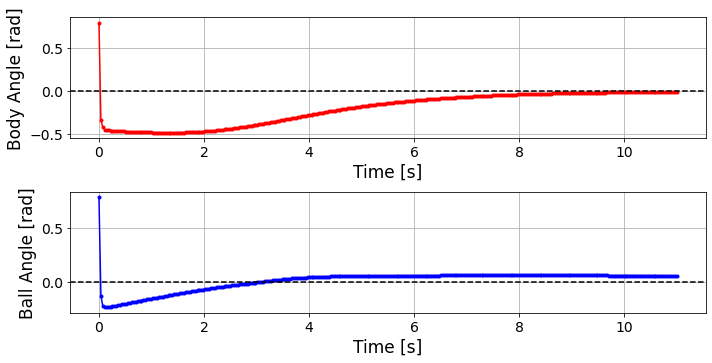

In [73]:
model.eval()

# Creating subplots
plt.figure(figsize=(10, 5))

# Subplot for THETA vs. T
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(T, STATE[:,0].detach().numpy(), marker='o', color='red', markersize = 3)  # Convert STATE tensor to numpy array for plotting
plt.axhline(y=0, color='black', linestyle='--')  # Add horizontal dashed line at y=0
plt.xlabel('Time [s]', fontsize = 17)
plt.ylabel('Body Angle [rad]', fontsize = 17)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase tick size
plt.grid(True)  # Show grid

# Subplot for PHI vs. T
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(T, STATE[:,1].detach().numpy(), marker='o', color='blue', markersize = 3)  # Convert STATE tensor to numpy array for plotting
plt.axhline(y=0, color='black', linestyle='--')  # Add horizontal dashed line at y=0
plt.xlabel('Time [s]', fontsize = 17)
plt.ylabel('Ball Angle [rad]', fontsize = 17)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase tick size
plt.grid(True)  # Show grid

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.savefig('prelim__{}_{}_{}_{}_{}.jpg'.format(n_snapshot, h_dim_x, n_layers_x, h_dim_u, n_layers_u), dpi = 600)
plt.show()

In [74]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with 2 rows and 1 column
fig = make_subplots(rows=1, cols=2)
# Subplot for THETA vs. T
fig.add_trace(go.Scatter(x=T, y=STATE[:, 0].detach().numpy(),
                         mode='lines+markers', line=dict(color='red', width=2),
                         marker=dict(color='red', size=5),
                         name='Body Angle', showlegend=False), row=1, col=1)

fig.add_trace(go.Scatter(x=T, y=[0] * len(T), mode='lines', line=dict(color='black', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_xaxes(title_text='Time [s]',title_font=dict(size=20), tickfont=dict(size=18), row=1, col=1)
fig.update_yaxes(title_text='Body Angle [rad]',title_font=dict(size=20), tickfont=dict(size=18), row=1, col=1)

# Subplot for PHI vs. T
fig.add_trace(go.Scatter(x=T, y=STATE[:, 1].detach().numpy(),
                         mode='lines+markers', line=dict(color='blue', width=2),
                         marker=dict(color='blue', size=5),
                         name='Ball Angle', showlegend=False), row=1, col=2)

fig.add_trace(go.Scatter(x=T, y=[0] * len(T), mode='lines', line=dict(color='black', dash='dash'),
                         showlegend=False), row=1, col=2)

fig.update_xaxes(title_text='Time [s]', title_font=dict(size=20), tickfont=dict(size=18), row=1, col=2)
fig.update_yaxes(title_text='Ball Angle [rad]', title_font=dict(size=20), tickfont=dict(size=18), row=1, col=2)
fig.update_layout(height=300, width=1200, margin=dict(l=0, r=10, t=20, b=35))
# Increase x-axis label font size
fig.write_image('prelim__{}_{}_{}_{}_{}.pdf'.format(n_snapshot, h_dim_x, n_layers_x, h_dim_u, n_layers_u))


fig.show()
